Lets upload data to colab

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import matplotlib.cm as cm
from IPython.core.display import display, HTML
from google.colab import files

In [0]:
uploaded = files.upload()

Saving ferdosi.txt to ferdosi.txt


**Data(mesraa) preparation ** 

In [0]:
#######################################Preparring data#################################################
class data_preparation:
    def __init__(self, path):
        self.path = path
        with open(path, encoding='utf-8') as f:
            lines = f.readlines()
            self.max_size  = 0
            self.all_chars_set = { '_BOM_','_PAD_', '_EOM_'}
            for line in lines:
                line = line.rstrip('\n')
                [first_m , second_m] = line.split(',')
                first_m = first_m.rstrip(' ').lstrip(' ')
                second_m = second_m.rstrip(' ').lstrip(' ')
                for c in first_m + second_m:
                    self.all_chars_set.add(c)
                self.max_size = max(self.max_size, len(first_m))
                self.max_size = max(self.max_size, len(second_m))
            self.all_chars_dic = {c : idx for idx, c in enumerate(self.all_chars_set)}
            self.n_chars = len(self.all_chars_dic)
            self.n_examples = len(lines)
            self.max_size += 2
    def get_data(self):
        X = np.zeros((self.n_examples, self.max_size))
        Y = np.zeros((self.n_examples, self.max_size))
        with open(self.path, encoding='utf-8') as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                line = line.rstrip('\n')
                [first_m , second_m] = line.split(',')
                first_m = first_m.rstrip(' ').lstrip(' ')
                second_m = second_m.rstrip(' ').lstrip(' ')
                X[i, :] = self.line2tensor(first_m, True)
                Y[i, :] = self.line2tensor(second_m, False)
        return X, Y
    def char2idx(self, c):
        return self.all_chars_dic[c]

    def idx2char(self, idx):
        for k, v in self.all_chars_dic.items():
            if v == idx:
                return k
        raise Exception('There is no', idx, ' in all_chars_dic')

    def tensor2line(self, tensor, tags=True):
        if tags:
            return ''.join(self.idx2char(tensor[i]) for i in range(tensor.shape[0]))
        else:
            return ''.join(self.idx2char(tensor[i]) for i in range(tensor.shape[0])
                            if self.idx2char(tensor[i]) not in ['_BOM_', '_EOM_', '_PAD_'])
    # add _BOM_ at the begining of line and _EOM_ at the end of line and _PAD_ based on first_flag
    def line2tensor(self, line, first_flag):
        sz = self.max_size
        tensor = np.zeros(sz)
        # pad from begining if it's first mesraa
        if first_flag:
            for i in range(0, sz-len(line)-2):
                tensor[i] = self.char2idx('_PAD_')
            tensor[sz-len(line)-2]  = self.char2idx('_BOM_')
            offset = sz - len(line) - 1
            tensor[-1] = self.char2idx('_EOM_')
        else:
            tensor[0] = self.char2idx('_BOM_')
            offset = 1
        for i, c in enumerate(line):
            tensor[i+offset] = self.char2idx(c)
            idx = self.char2idx(c)
        # pad at the end if it's second hemistich
        if not first_flag:
            tensor[len(line)+offset] = self.char2idx('_EOM_')
            offset += 1
            for i in range(len(line)+offset, sz):
                tensor[i] = self.char2idx('_PAD_')
        return tensor


Model architecture(Sequence2Sequence with and without attention)

In [0]:
##########################Model architecture############################
class Embedding:
  def __init__(self, input_dim, embedding_dim):
    with tf.variable_scope("Embedding", reuse=tf.AUTO_REUSE):
      self.word_embeddings = tf.get_variable(name='word_embedding', shape=[input_dim, embedding_dim], initializer=tf.random_uniform_initializer(-1, 1))

  def __call__(self, input):
    with tf.variable_scope("Embedding", reuse=tf.AUTO_REUSE):
      embedded = tf.nn.embedding_lookup(self.word_embeddings, input)
      return embedded

class encoder_RNN:
  def __init__(self, input_dim, hidden_dim, n_layers):
    with tf.variable_scope("encoder_RNN", reuse=tf.AUTO_REUSE):
      self.hidden_dim = hidden_dim
      self.input_dim = input_dim
      self.n_layers = n_layers

      cells = [tf.nn.rnn_cell.LSTMCell(num_units=hidden_dim, use_peepholes=True, state_is_tuple=True) for n in range(n_layers)]
      self.lstm = tf.contrib.rnn.MultiRNNCell(cells)

  def __call__(self, input, hidden):
    with tf.variable_scope("encoder_RNN", reuse=tf.AUTO_REUSE):
      output, hidden = tf.nn.dynamic_rnn(self.lstm, input, initial_state=hidden)
      return output, hidden

  def init_hidden(self, n_batches):
    return self.lstm.zero_state(n_batches, dtype=tf.float32)

class decoder_RNN:
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
    with tf.variable_scope("decoder_RNN", reuse=tf.AUTO_REUSE):
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.output_dim = output_dim
      self.n_layers = n_layers
      cells = [tf.nn.rnn_cell.LSTMCell(num_units=hidden_dim, use_peepholes=True, state_is_tuple=True) for n in range(n_layers)]
      self.lstm = tf.contrib.rnn.MultiRNNCell(cells)
      self.W = tf.get_variable('W', shape=[hidden_dim, output_dim], initializer=tf.contrib.layers.xavier_initializer())
      self.b = tf.get_variable('b', shape=[output_dim], initializer=tf.zeros_initializer())
  def __call__(self, input, hidden):
    with tf.variable_scope("decoder_RNN", reuse=tf.AUTO_REUSE):
      output, hidden = self.lstm(input, hidden)
      output = tf.tensordot(output, self.W, axes=1) + self.b
      return output, hidden
class Attn_decoder_RNN:
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
    with tf.variable_scope("Attention_decoder_RNN", reuse=tf.AUTO_REUSE):
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.output_dim = output_dim
      self.n_layers = n_layers
      cells = [tf.nn.rnn_cell.LSTMCell(num_units=hidden_dim, use_peepholes=True, state_is_tuple=True) for n in range(n_layers)]
      self.lstm = tf.contrib.rnn.MultiRNNCell(cells)
      self.W = tf.get_variable('W', shape=[hidden_dim, output_dim], initializer=tf.contrib.layers.xavier_initializer())
      self.b = tf.get_variable('b', shape=[output_dim], initializer=tf.zeros_initializer())
  def __call__(self, input, hidden):
    with tf.variable_scope("Attention_decoder_RNN", reuse=tf.AUTO_REUSE):
      output, hidden = self.attn_cell(input, hidden)
      output = tf.tensordot(output, self.W, axes=1) + self.b
      return output, hidden
  def init_hidden(self, batch_dim, hidden):
    return self.attn_cell.get_initial_state(hidden.h, batch_dim, dtype=tf.float32)
  def set_memory(self, memory):
    with tf.variable_scope("Attention_decoder_RNN", reuse=tf.AUTO_REUSE):
      self.attn = tf.contrib.seq2seq.BahdanauAttention(num_units=self.hidden_dim, memory=memory)
      self.attn_cell = tf.contrib.seq2seq.AttentionWrapper(self.lstm, self.attn, alignment_history=True)
class Seq2SeqModel:
  def __init__(self, encoder, decoder, embedding, max_len, begin_char):
    with tf.variable_scope("Seq2Seq", reuse=tf.AUTO_REUSE):
      self.encoder = encoder
      self.decoder = decoder
      self.embedding = embedding
      attention = (type(decoder) == Attn_decoder_RNN)
      self.input_data = tf.placeholder(shape=[None, max_len], dtype=tf.int64)
      self.target_data = tf.placeholder(shape=[None, max_len], dtype=tf.int64)
      self.teacher_forcing = tf.placeholder(tf.float32, [])
      self.learning_rate = tf.placeholder(tf.float32, [])
      output_dim = self.decoder.output_dim
      batch_dim = tf.shape(self.input_data)[0]
      enc_embbeded_input = self.embedding(self.input_data)
      enc_output, enc_hidden = self.encoder(enc_embbeded_input, self.encoder.init_hidden(batch_dim))
      dec_hidden = enc_hidden
      dec_input = tf.tile([begin_char], tf.shape(self.input_data)[0:1])
      dec_input = tf.dtypes.cast(dec_input, tf.int64)
      prediction = [dec_input]
      self.loss = 0
      if attention:
        self.decoder.set_memory(enc_output)
        dec_hidden = self.decoder.init_hidden(batch_dim, dec_hidden[-1])
      for t in range(1, max_len):
        dec_embedded_input = self.embedding(dec_input)
        dec_output, dec_hidden = self.decoder(dec_embedded_input, dec_hidden)
        self.loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
                      labels=tf.one_hot(self.target_data[:, t], depth=output_dim, dtype=tf.float32),
                      logits=dec_output))
        next_char = tf.argmax(dec_output, axis=1)
        prediction.append(next_char)
        teacher_forcing = tf.cond(random.random() < self.teacher_forcing, lambda: True, lambda: False)
        dec_input = tf.cond(teacher_forcing, lambda: self.target_data[:, t], lambda: next_char)
      if attention:
        self.attn_weights = dec_hidden.alignment_history.stack()
      self.prediction = tf.transpose(tf.convert_to_tensor(prediction))
      self.loss /= max_len
      optimizer = tf.train.AdamOptimizer(self.learning_rate)
      self.opt = optimizer.minimize(self.loss)


In [0]:
loader = data_preparation('ferdosi.txt')
(X, Y) = loader.get_data()
idx = np.random.permutation(X.shape[0])
X, Y = X[idx, :], Y[idx, :]
test_r = 0.1
val_r = 0.1
ind1 = int(X.shape[0] * (1-test_r-val_r))
ind2 = int(X.shape[0] * (1-test_r))
X_train, Y_train = X[:ind1, :], Y[:ind1, :]
X_valid, Y_valid = X[ind1:ind2, :], Y[ind1:ind2, :]
X_test, Y_test = X[ind2:, :], Y[ind2:, :]
data = {'X_train':X_train, 'Y_train':Y_train,
        'X_valid':X_valid, 'Y_valid':Y_valid,
        'X_test':X_test, 'Y_test':Y_test}
params={'batch_size' : 256,'epochs' : 100,'vocabulary_size' : loader.n_chars,'MAX_LEN' : loader.max_size,'EMBEDDING_dim' : 32,'hidden_size' : 256,'the number of layers' : 2,'BEGIN_CHAR' : loader.all_chars_dic['_BOM_'],'learning_rate' : 1e-3,'learning_rate_decay' : 1,'learning_rate_decay_step' : 20,'learning_rate_min': 1e-5,'eps' : 1,'eps_dec' : 0.95,'eps_dec_step' : 30,'eps_thr' : .8}



In [0]:
def train(model, data, params, print_every=10):
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  num_of_batches = np.ceil(data['X_train'].shape[0] / params['batch_size'])
  
  loss_history = []
  
  for epoch in range(1, params['epochs']+1):
      epoch_loss = 0
      if epoch % params['learning_rate_decay_step'] == 0: params['learning_rate'] *= params['learning_rate_decay']
      if epoch % params['eps_dec_step'] == 0: params['eps'] = max(params['eps_thr'], params['eps'] * params['eps_dec'])
        
      for i in range(0, data['X_train'].shape[0],  params['batch_size']):
        X_b = data['X_train'][i:i+params['batch_size']]
        Y_b = data['Y_train'][i:i+params['batch_size']]

        _, loss = sess.run([model.opt, model.loss], feed_dict={model.input_data: X_b, 
                                                               model.target_data: Y_b,
                                                               model.learning_rate: params['learning_rate'],
                                                               model.teacher_forcing: params['eps']})
        epoch_loss += loss / num_of_batches
      loss_history.append(epoch_loss)
      if epoch % print_every == 0:
        print("epoch {}, Loss:{}".format(epoch, epoch_loss))
        idx = np.random.randint(0, data['X_valid'].shape[0])
        pred = sess.run(model.prediction, feed_dict={model.input_data: data['X_valid'][idx].reshape(1, -1),
                                                     model.target_data: data['Y_valid'][idx].reshape(1, -1),
                                                     model.teacher_forcing: 0})[0]
        print('completed(predicted) poem from validation set:')
        print((loader.tensor2line(data['X_valid'][idx], False) + "  ****  " + loader.tensor2line(pred, False)))
        print(150*'-')
  return sess, loss_history

epoch 10, Loss:0.9912832929537847
completed(predicted) poem from validation set:
خردمند چون روی گشتاسپ دید  ****  به نزدیک این را بدین افرید
------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 20, Loss:0.8276944907429893
completed(predicted) poem from validation set:
سر تخم ساسانیان بود شاه  ****  که این را نبودی به نزدیک شاه
------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 30, Loss:0.9211508917311825
completed(predicted) poem from validation set:
سپیدی مویش بزیبد همی  ****  زر از درد و بر دشت از اندکی
------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 40, Loss:0.7616484087342635
completed(predicted) poem from validation set:
توی پشت ایران و تاج سران  ****  ز دیتی به کردار

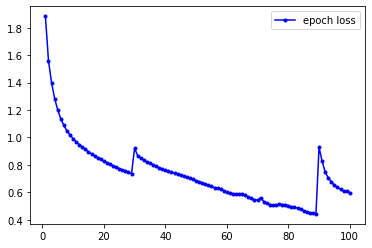

In [0]:
tf.reset_default_graph()
embedding = Embedding(params['vocabulary_size'], params['EMBEDDING_dim'])
encoder = encoder_RNN(params['vocabulary_size'], params['hidden_size'], params['the number of layers'])
decoder = decoder_RNN(params['vocabulary_size'], params['hidden_size'], params['vocabulary_size'], params['the number of layers'])
model  = Seq2SeqModel(encoder, decoder, embedding, params['MAX_LEN'], params['BEGIN_CHAR'])
model_sess, loss_history = train(model, data, params.copy())
test_loss = model_sess.run(model.loss, feed_dict={model.input_data: data['X_test'], model.target_data: data['Y_test'],model.teacher_forcing: 0})
print('Test Loss:', test_loss)
plt.plot(range(1, params['epochs']+1), loss_history, '-b.',label='epoch loss')
plt.legend()
plt.show()

Attention model

epoch 10, Loss:1.215521026116151
completed(predicted) poem from validation set:
که پشت همه شهر توران بدوست  ****  بران بر بران بر براند اوری
------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 20, Loss:0.996352766186763
completed(predicted) poem from validation set:
تهمتن چو بشنید گفتار اوی  ****  به بالای او راه بر باد کرد
------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 30, Loss:0.9759732563144121
completed(predicted) poem from validation set:
نه شبرنگ با من نه رهوار بور  ****  به باره بران روز بر بر و روز
------------------------------------------------------------------------------------------------------------------------------------------------------
epoch 40, Loss:0.8668158988539987
completed(predicted) poem from validation set:
دو خونی همان با سپاهی گران  ****  به باره

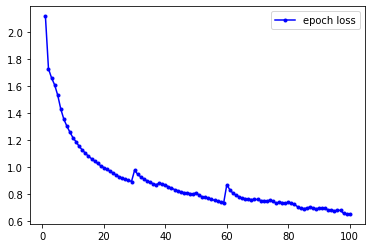

In [0]:
tf.reset_default_graph()
embedding = Embedding(params['vocabulary_size'], params['EMBEDDING_dim'])
encoder = encoder_RNN(params['vocabulary_size'], params['hidden_size'], params['the number of layers'])
attn_decoder = Attn_decoder_RNN(params['vocabulary_size'], params['hidden_size'], params['vocabulary_size'], params['the number of layers'])
attn_model  = Seq2SeqModel(encoder, attn_decoder, embedding, params['MAX_LEN'], params['BEGIN_CHAR'])
attn_model_sess, loss_history = train(attn_model, data, params.copy())
test_loss = attn_model_sess.run(attn_model.loss, feed_dict={attn_model.input_data: data['X_test'], attn_model.target_data: data['Y_test'],attn_model.teacher_forcing: 0})
print('Test Loss:', test_loss)
plt.plot(range(1, params['epochs']+1), loss_history, '-b.',label='epoch loss')
plt.legend()
plt.show()

Predicting second mesraaa by attention and without that

In [0]:
for i in range(10):
  idx = np.random.randint(0, data['X_test'].shape[0])
  pred = model_sess.run(model.prediction, feed_dict={model.input_data: data['X_test'][idx].reshape(1, -1),model.target_data: data['Y_test'][idx].reshape(1, -1),model.teacher_forcing: 0})
  attn_pred, weights = attn_model_sess.run([attn_model.prediction, attn_model.attn_weights], feed_dict={attn_model.input_data: data['X_test'][idx].reshape(1, -1),attn_model.target_data: data['Y_test'][idx].reshape(1, -1),attn_model.teacher_forcing: 0})
  first_m = loader.tensor2line(data['X_test'][idx], False)
  second_m_true = loader.tensor2line(data['Y_test'][idx], False)
  second_m_1 = loader.tensor2line(pred[0], False)
  second_m_2 = loader.tensor2line(attn_pred[0], False)
  print('Test input:',i)
  print(first_m + "  ****  " + second_m_true)
  print('Seq2Seq output:')
  print(second_m_1)
  print('Seq2Seq with attention output:')
  print(second_m_2)

Test input: 0
چنین داد پاسخ که گر شهریار  ****  براندیشد از کار اسفندیار
Seq2Seq output:
به این نامداران رومی مدار
Seq2Seq with attention output:
بران نامور بخرگاه اندرار
Test input: 1
ز فرهاد و گیوت برارم بجاه  ****  بگنج و سپاه و بتخت و کلاه
Seq2Seq output:
بران را به ایران نیاین به راه
Seq2Seq with attention output:
برفتند با او به ایوان شاه
Test input: 2
همان تیغ هندی و رومی هزار  ****  بفرمود با جوشن کارزار
Seq2Seq output:
سرامد برو رنجه شیرخور
Seq2Seq with attention output:
بران نامور تخت شاهی نگار
Test input: 3
به خسرو چنین گفت کای سرفراز  ****  نگه کن بدان بنده دیوساز
Seq2Seq output:
به چنگ اندرون گرز و گردش نیاز
Seq2Seq with attention output:
بران بر نشینم مرا رهنماز
Test input: 4
چو هم پشت باشید با همرهان  ****  یکی کوه کندن ز بن بر توان
Seq2Seq output:
بب شید و بر ماه پیر مهان
Seq2Seq with attention output:
بران شار بر تخت بر شاهان
Test input: 5
چو دو ابگیرش پر از خون دو چشم  ****  مرا دید غرید و امد به خشم
Seq2Seq output:
بکی اتش از بر یکی گرد نشم
Seq2Seq with attention out